In [4]:
import os
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.optim

$$
L = \mathbb{E}[\log D(X)] + \mathbb{E}[\log(1 - D(G(z)))]
$$

* $D(X)$ : real discrimination
* $G(D(X))$ : fake_discrimination 

In [ ]:
def minmax_discriminator_loss(real_discrimination, fake_discrimination):
    real_loss = torch.mean(torch.log(real_discrimination))
    fake_loss = torch.mean(torch.log(1-fake_discrimination))

    return -(real_loss + fake_loss) #change problem to minimization

# discriminator는 maximize가 목표이다.
# 하지만 optimizer의 기본 구현이 gradient descent(minimize)이기 때문에 (-)를 곱해준다.

def minmax_generator_loss(fake_discrimination):
    return torch.mean(torch.log(1-fake_discrimination))

# Generator가 최소화해야 하는 log(1-D(G(z)))의 그래프를 보면 0 근처에서 gradient가 굉장히 작음.

Generator가 최소화해야 하는 $\mathbb{E}[\log(1 - D(G(z)))]$의 그래프를 보면 0 근처에서 gradient가 굉장히 작음.

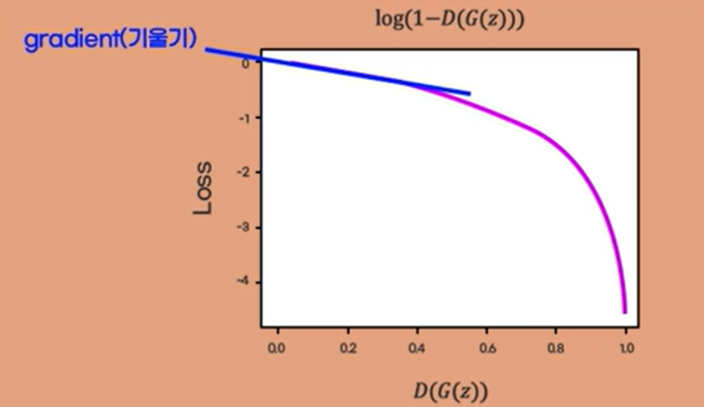

Discriminator가 학습 초반엔 굉장히 잘 구분하기 때문에 fake image는 0에 가까운 평가를 받을 확률이 높다.

> Generator로 전달되는 gradient가 작아서 학습속도가 느림

이를 위해 $-\mathbb{E}[\log(D(G(z)))]$ 로 수식을 변경함으로써

> fake image 판별 결과가 0에 가까울 수록 loss가 높게 설정.

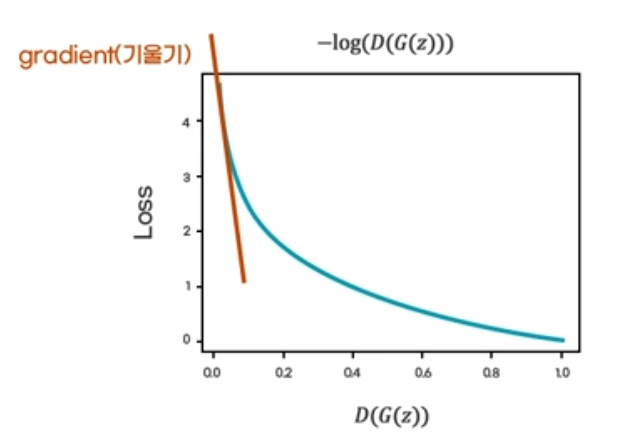

In [ ]:
def modified_generator_loss(fake_discrimination):
    return -torch.mean(torch.log(fake_discrimination))

In [7]:
class GAN(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.generator = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 784),   # 28*28 = 784
        nn.Sigmoid(),
        )

        self.discriminator = nn.Sequential( # 이미지를 입력받음
            nn.Linear(784, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def generate(self, z):
        return self.generator(z).view(-1, 1, 28, 28)
    
    def discriminate(self, x):
        return self.discriminator(x.view(-1, 784))

학습에 필요한 파라미터들을 순서대로 정리해 둔 변수, cfg 딕셔너리

In [3]:
if __name__ == "__main__":
    global cfg
    cfg = {
        'epoch' : 40,
        'lr' : 0.001,
        'z_dim': 100,
        'batch_size':128,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    }


In [11]:
def get_dataloader():
    train_path = './data/mnist/train'
    test_path = './data/mnist/test'

    transforms = T.Compose([
        T.RandomResizedCrop(size = 28, scale = (0.8, 1.0), ratio = (1.0, 1.0)),
        T.ToTensor()
    ])
    
    train_dataset = torchvision.datasets.MNIST(root = train_path, train = True, transform = transforms, download = True)
    test_dataset = torchvision.datasets.MNIST(root = test_path, train = False, transform = transforms, download = True)
    dataset = torch.utils.data.ConcatDatasets([train_dataset, test_dataset])

    dataloader = DataLoader(dataset, batch_size = cfg['batch_size'], shuffle = True, num_workers = -1, drop_last = True)

    return dataloader

## Main()

In [12]:
def main():
    model = GAN(cfg['z_dim']).to(cfg['device'])
    dataloader = get_dataloader()
    
    opt_Generator = torch.optim.Adam(model.generator.parameters(), lr = cfg['lr'])
    opt_Discriminator = torch.optim.Adam(model.discriminator.parameters(), lr = cfg['lr'])

    os.makedirs('./GAN/results', exist_ok = True)
    os.makedirs('./GAN/checkpoints', exist_ok = True)
    
    fixed_z = torch.randn(100, cfg['z_dim']).to(cfg['device']) # 100장 미리 만들어 놓기


In [ ]:
main()

## Training

In [ ]:
for epoch in range(1, cfg['epochs'] +1):
    print(f'Epoch {epoch} / {cfg['epochs']}')

    model.train()
    for data, _ in dataloader: # _는 라벨인데 이 task에선 필요 없음
        data = data.to(cfg['device'])

    # Trian Discriminator
    opt_Discriminator.zero_grad()
    z = torch.randn(cfg['batch_size'], cfg['z_dim']).to(cfg['device'])
    with torch.no_grad(): # 구하되 update는 X
        fake = model.generate(z)
    real_discrimination = model.discriminate(real)
    fake_discrimination = model.discriminate(fake)
    loss_D = modified_generator_loss(real_discrimination, fake_discrimination)
    loss_D.backward()
    opt_Discriminator.step()

    # Train Generator
    opt_Generator.zero_grad()
    z = torch.randn(cfg['batch_size'], cfg['z_dim']).to(cfg['device'])
    fake = model.generate(z)
    fake_discrimination = model.discriminate(fake)
    loss_G = modified_generator_loss(fake_discrimination)
    loss_G.backward()
    opt_Generator.step()



## Test

In [ ]:
# test
model.eval()
fake = model.generate(fixed_z)
discrimination = model.discriminate(fake)

# save
fake = fake.cpu().numpy() # plt는 gpu에 있으면 안돌아감.
discrimination = discrimination.cpu()
fig, ax = plt.subplots(10, 10, figsize=(20,20))...
